### Import the dependencies

In [1]:
%load_ext lab_black

# Common Imports
import numpy as np
import pandas as pd

# Preprocessing
from scipy.stats import norm

# Assessing performance
from sklearn.metrics import mean_squared_error

# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# Fine Tuning
from sklearn.model_selection import GridSearchCV

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings

warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", category=UserWarning)

# To make this notebook's output identical at every run
np.random.seed(42)

### Inspect the data

In [2]:
data = (
    pd.read_csv("position_log_v2.csv")
    .query("marker != 8")  # too many null values for tag 1
    .query("marker % 2 == 0")
    .drop(["z", "anchors"], axis=1)
    .reset_index(drop=True)
)

data["tag"] = data["tag"].replace(52630, 3)

data["marker"] = data["marker"].map(
    {j: i + 1 for i, j in enumerate(data.marker.unique())}
)

data.columns = [
    "position",
    "time",
    "tag",
    "x",
    "y",
    "anchor_1",
    "anchor_2",
    "anchor_3",
    "anchor_4",
    "anchor_5",
]

data = data.loc[:, ["tag", "x", "y", "position"]]
data

,tag,x,y,position
0,1,1595,1916,1
1,2,1614,1989,1
2,3,1620,1971,1
3,1,1595,1915,1
4,2,1614,1988,1
...,...,...,...,...
27655,2,1315,1863,11
27656,3,1345,1886,11
27657,1,1313,1899,11
27658,2,1315,1861,11


#### Look at the noise at each of the different locations

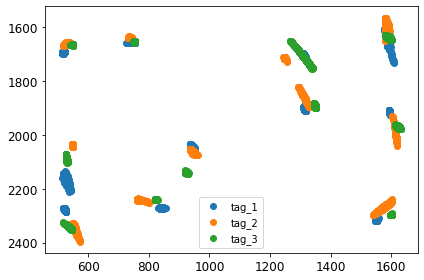

In [3]:
ax = plt.gca()
ax.invert_yaxis()
ax.scatter(data.query("tag == 1").x, data.query("tag == 1").y, label="tag_1")
ax.scatter(data.query("tag == 2").x, data.query("tag == 2").y, label="tag_2")
ax.scatter(data.query("tag == 3").x, data.query("tag == 3").y, label="tag_3")

plt.legend(loc="best")
plt.tight_layout()
plt.savefig("1.png", transparent=True)
plt.show()

#### Look at the noise in each tag at each of the different locations

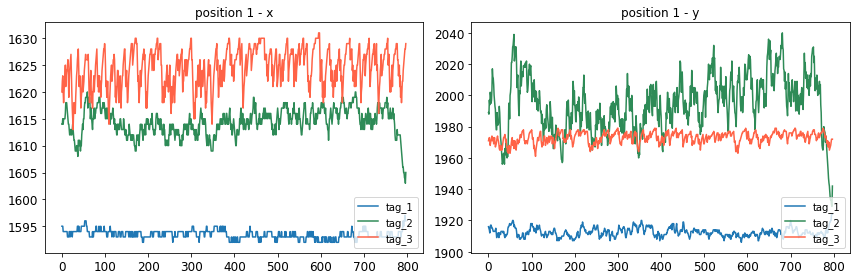

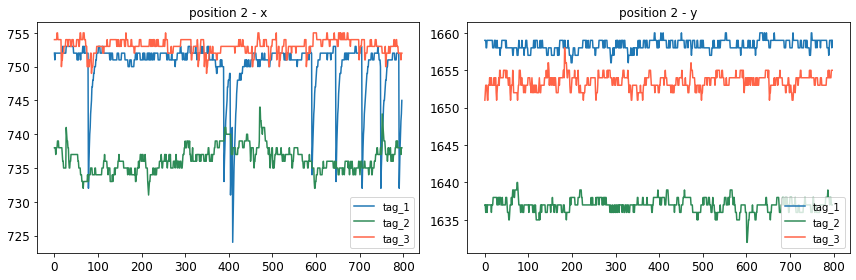

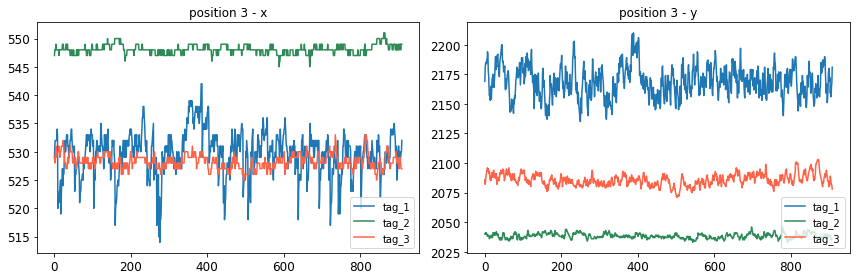

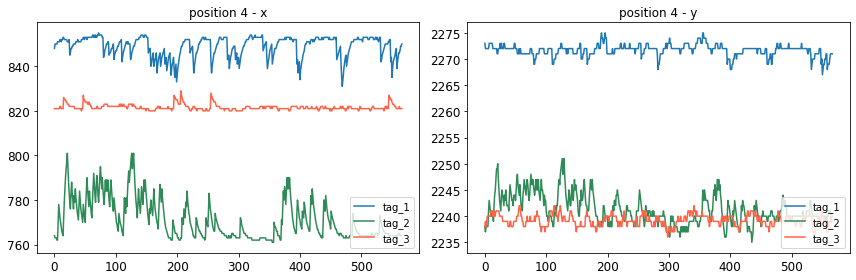

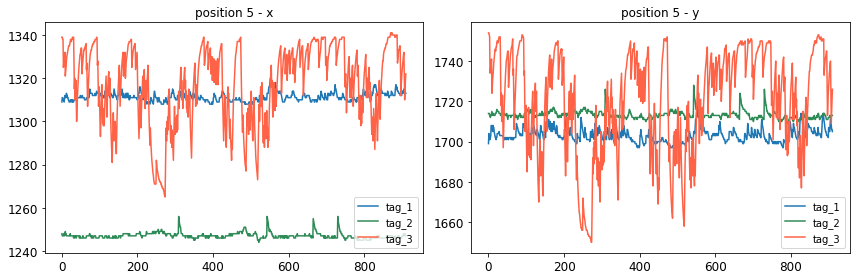

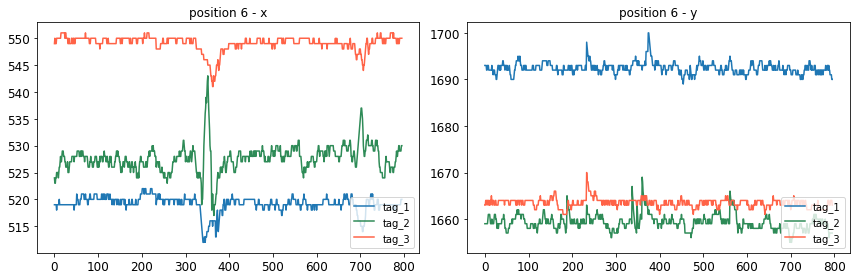

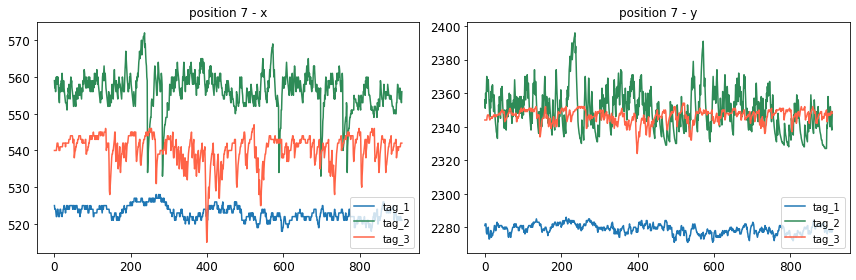

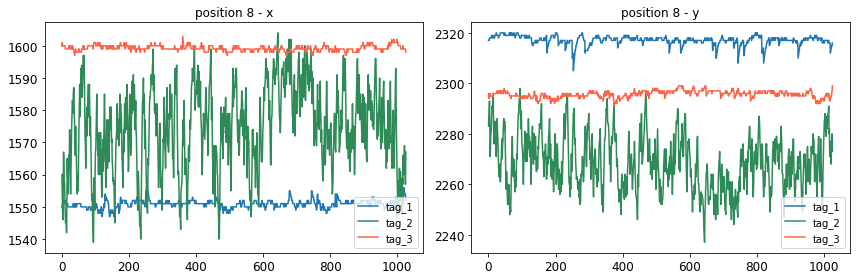

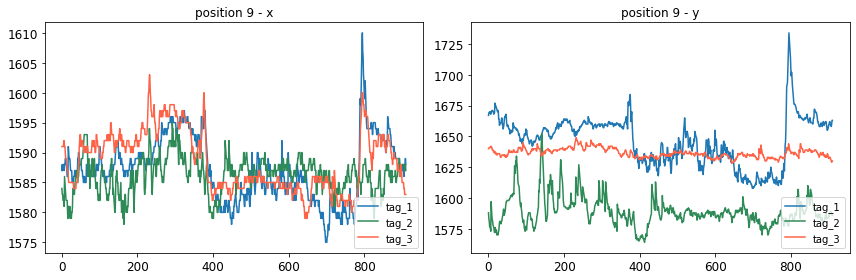

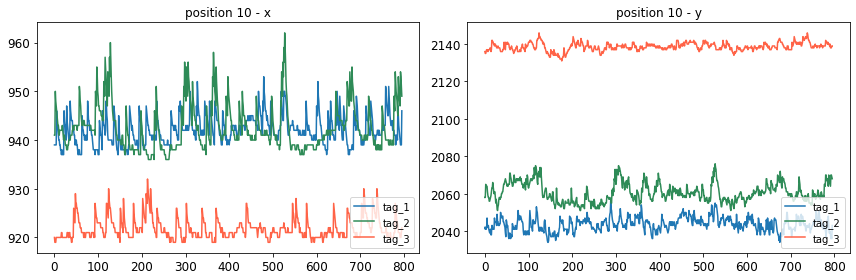

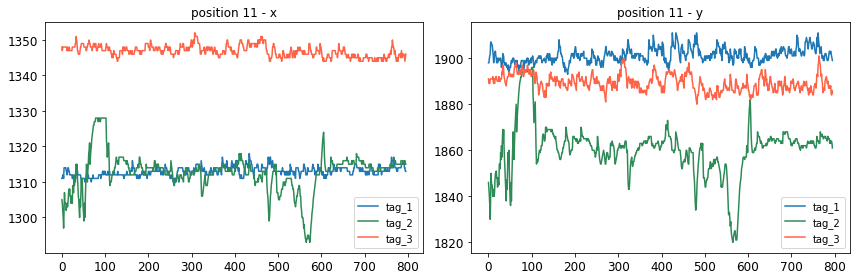

In [4]:
for i in data["position"].unique():
    tag_1_x = data.query(f"position == {i} & tag == 1").x.reset_index(drop=True)
    tag_2_x = data.query(f"position == {i} & tag == 2").x.reset_index(drop=True)
    tag_3_x = data.query(f"position == {i} & tag == 3").x.reset_index(drop=True)

    tag_1_y = data.query(f"position == {i} & tag == 1").y.reset_index(drop=True)
    tag_2_y = data.query(f"position == {i} & tag == 2").y.reset_index(drop=True)
    tag_3_y = data.query(f"position == {i} & tag == 3").y.reset_index(drop=True)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].plot(tag_1_x, label="tag_1")
    axes[0].plot(tag_2_x, label="tag_2", color="seagreen")
    axes[0].plot(tag_3_x, label="tag_3", color="tomato")
    axes[0].legend(loc="lower right")
    axes[0].title.set_text(f"position {i} - x")

    axes[1].plot(tag_1_y, label="tag_1")
    axes[1].plot(tag_2_y, label="tag_2", color="seagreen")
    axes[1].plot(tag_3_y, label="tag_3", color="tomato")
    axes[1].legend(loc="lower right")
    axes[1].title.set_text(f"position {i} - y")

    fig.tight_layout()
    fig.show()

#### Plot the histogram and the PDF for each tag and each position 

##### x coordinates

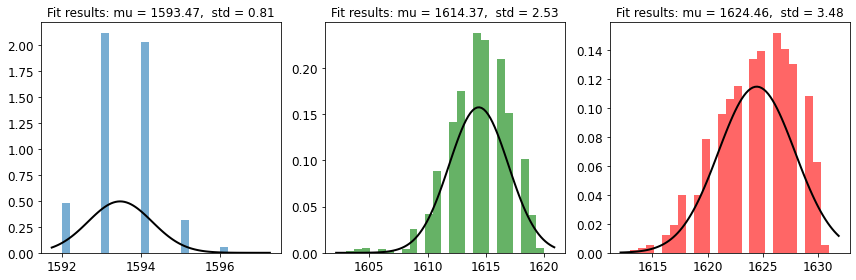

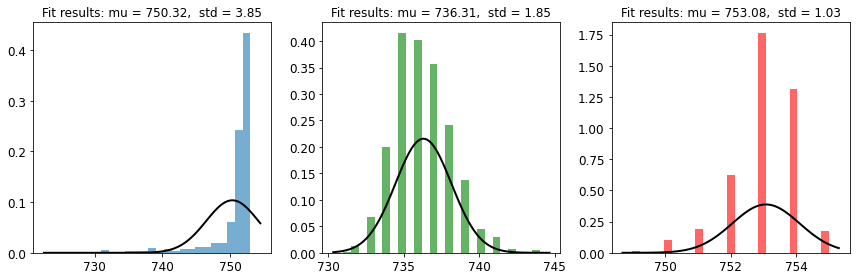

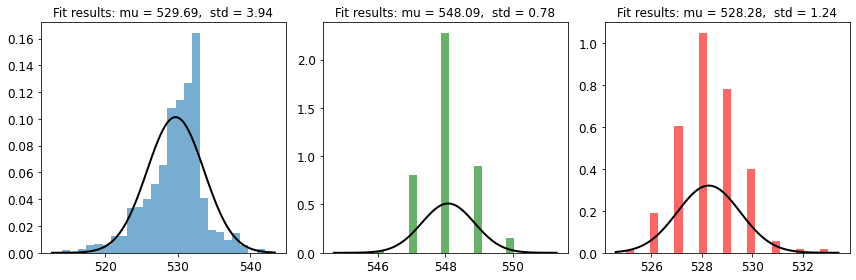

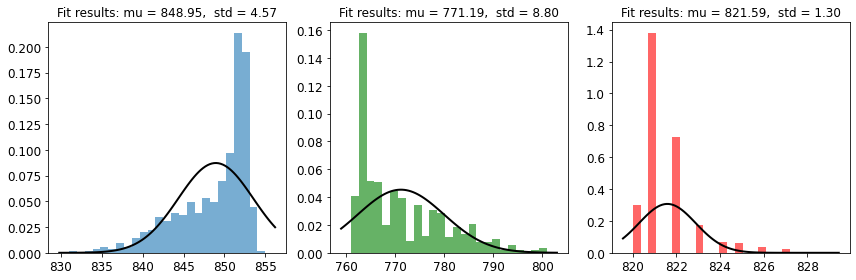

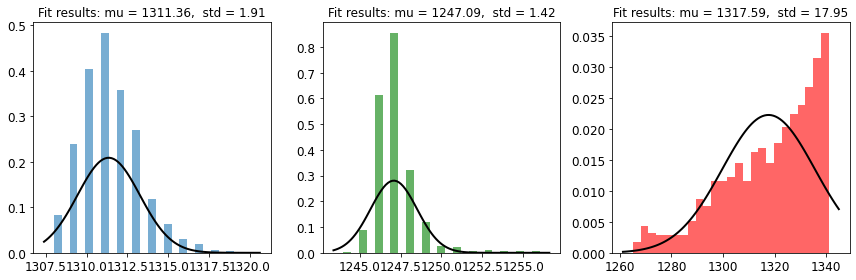

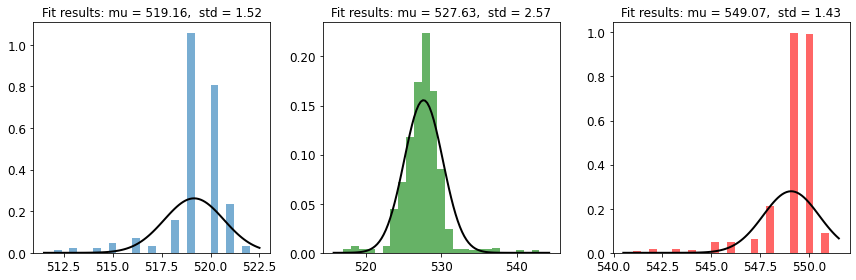

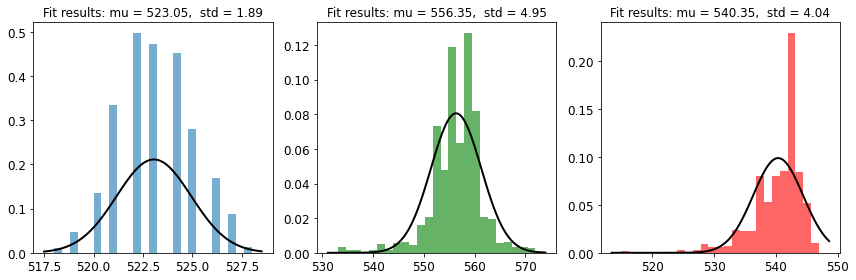

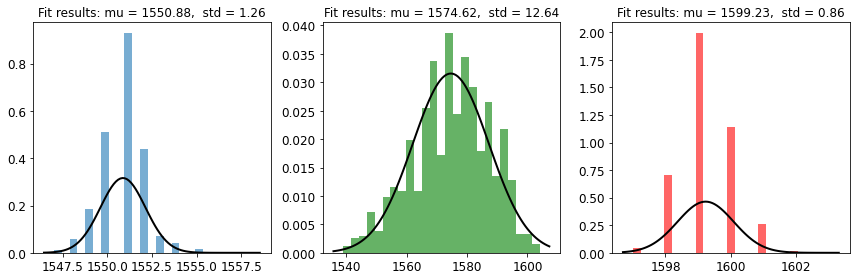

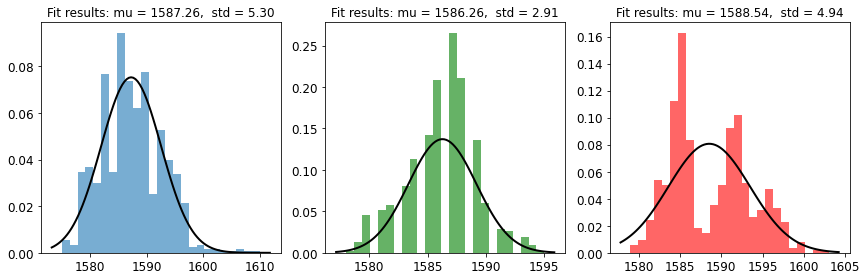

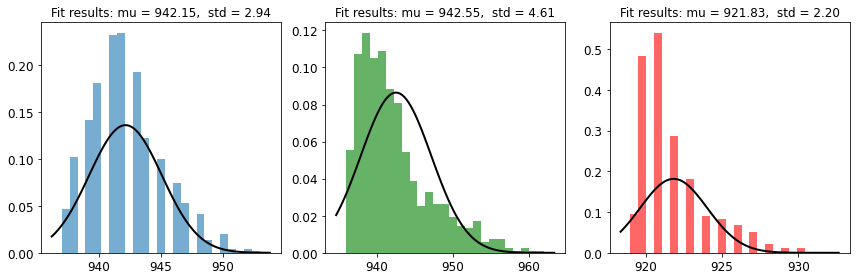

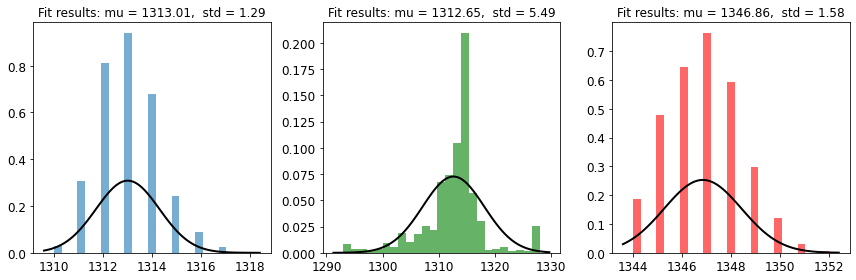

In [100]:
for i in sorted(data["position"].unique()):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    tag_1 = data.query(f"position == {i} & tag == 1").x
    tag_2 = data.query(f"position == {i} & tag == 2").x
    tag_3 = data.query(f"position == {i} & tag == 3").x

    # Fit a normal distribution to the data:
    mu_1, std_1 = norm.fit(tag_1)
    mu_2, std_2 = norm.fit(tag_2)
    mu_3, std_3 = norm.fit(tag_3)

    # Plot the histogram.
    axes[0].hist(tag_1, bins=25, density=True, alpha=0.6)
    axes[1].hist(tag_2, bins=25, density=True, alpha=0.6, color="g")
    axes[2].hist(tag_3, bins=25, density=True, alpha=0.6, color="r")

    # Plot the PDF.
    xmin, xmax = axes[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_1, std_1)
    axes[0].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_1, std_1)
    axes[0].title.set_text(title)

    # Plot the PDF.
    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_2, std_2)
    axes[1].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_2, std_2)
    axes[1].title.set_text(title)

    # Plot the PDF.
    xmin, xmax = axes[2].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_3, std_3)
    axes[2].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_3, std_3)
    axes[2].title.set_text(title)

    fig.tight_layout()
    fig.show()

    fig.savefig(f"graphs/pos_{i}_x.png", bbox_inches="tight")

##### y coordinates

In [ ]:
for i in sorted(data["position"].unique()):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    tag_1 = data.query(f"position == {i} & tag == 1").y
    tag_2 = data.query(f"position == {i} & tag == 2").y
    tag_3 = data.query(f"position == {i} & tag == 3").y

    # Fit a normal distribution to the data:
    mu_1, std_1 = norm.fit(tag_1)
    mu_2, std_2 = norm.fit(tag_2)
    mu_3, std_3 = norm.fit(tag_3)

    # Plot the histogram.
    axes[0].hist(tag_1, bins=25, density=True, alpha=0.6)
    axes[1].hist(tag_2, bins=25, density=True, alpha=0.6, color="g")
    axes[2].hist(tag_3, bins=25, density=True, alpha=0.6, color="r")

    # Plot the PDF.
    xmin, xmax = axes[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_1, std_1)
    axes[0].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_1, std_1)
    axes[0].title.set_text(title)

    # Plot the PDF.
    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_2, std_2)
    axes[1].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_2, std_2)
    axes[1].title.set_text(title)

    # Plot the PDF.
    xmin, xmax = axes[2].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_3, std_3)
    axes[2].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_3, std_3)
    axes[2].title.set_text(title)

    fig.tight_layout()
    fig.show()

    fig.savefig(f"graphs/pos_{i}_y.png", bbox_inches="tight")

***
## Approach 1: Model on all the data

### Baseline

Position 1:
Actual: (1597, 1958)
Calc:   (1610, 1959)
Distance: 13.038404810405298
Number of Data Points: 798.0

Position 2:
Actual: (766, 1690)
Calc:   (746, 1649)
Distance: 45.617978911828175
Number of Data Points: 798.0

Position 3:
Actual: (530, 2040)
Calc:   (535, 2097)
Distance: 57.21887800367987
Number of Data Points: 910.0

Position 4:
Actual: (839, 2244)
Calc:   (813, 2250)
Distance: 26.68332812825267
Number of Data Points: 567.0

Position 5:
Actual: (1269, 1744)
Calc:   (1292, 1712)
Distance: 39.408120990476064
Number of Data Points: 911.0

Position 6:
Actual: (530, 1690)
Calc:   (531, 1671)
Distance: 19.026297590440446
Number of Data Points: 796.0

Position 7:
Actual: (530, 2302)
Calc:   (539, 2325)
Distance: 24.698178070456937
Number of Data Points: 911.0

Position 8:
Actual: (1597, 2302)
Calc:   (1574, 2293)
Distance: 24.698178070456937
Number of Data Points: 1026.0

Position 9:
Actual: (1597, 1690)
Calc:   (1587, 1624)
Distance: 66.75327707311455
Number of Data Points: 91

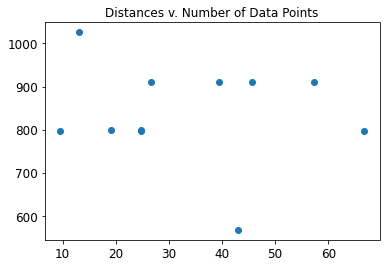

In [3]:
x_pos = [1597, 766, 530, 839, 1269, 530, 530, 1597, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 2302, 2302, 1690, 2083, 1925]

true_pos = zip(x_pos, y_pos)

num_data_points = data["position"].value_counts().div(3).to_dict()
distances_to_tags = []

for i in sorted(data["position"].unique()):
    tag_1 = data.query(f"position == {i} & tag == 1")
    tag_2 = data.query(f"position == {i} & tag == 2")
    tag_3 = data.query(f"position == {i} & tag == 3")

    x_avg_calc = int((tag_1.x.mean() + tag_2.x.mean() + tag_3.x.mean()) / 3)
    y_avg_calc = int((tag_1.y.mean() + tag_2.y.mean() + tag_3.y.mean()) / 3)

    x_avg_actual, y_avg_actual = next(true_pos)

    distance = (
        ((x_avg_calc - x_avg_actual) ** 2) + ((y_avg_calc - y_avg_actual) ** 2)
    ) ** 0.5

    distances_to_tags.append(distance)

    print(f"Position {i}:")
    print("Actual:", (x_avg_actual, y_avg_actual))
    print("Calc:  ", (x_avg_calc, y_avg_calc))
    print("Distance:", distance)
    print("Number of Data Points:", num_data_points[i])
    print()

ax = plt.gca()
ax.scatter(distances_to_tags, num_data_points.values())
ax.title.set_text("Distances v. Number of Data Points")
plt.show()

### Predict the x_coord

In [24]:
x_pos = [1597, 766, 530, 839, 1269, 530, 530, 1597, 1597, 944, 1315]
x_pos_dict = dict(enumerate(x_pos, 1))

data_tag_1 = data.query("tag == 1").loc[:, ["position", "x"]].reset_index(drop=True)
data_tag_2 = data.query("tag == 2").loc[:, ["x"]].reset_index(drop=True)
data_tag_3 = data.query("tag == 3").loc[:, ["x"]].reset_index(drop=True)

data_tag_1.columns = map("{}_tag_1".format, data_tag_1.columns)
data_tag_2.columns = map("{}_tag_2".format, data_tag_2.columns)
data_tag_3.columns = map("{}_tag_3".format, data_tag_3.columns)

data_mod_x = data_tag_1.join([data_tag_2, data_tag_3]).rename(
    columns={"position_tag_1": "position"}
)

# take position 1-8 in the test set
X_train_x = data_mod_x.query("position < 9").drop("position", axis=1)
Y_train_x = data_mod_x.query("position < 9")["position"].copy().map(x_pos_dict)

# take position 9-11 in the test set
X_test_x = data_mod_x.query("position >= 9").drop("position", axis=1)
Y_test_x = data_mod_x.query("position >= 9")["position"].copy().map(x_pos_dict)

# display the training set
X_train_x.join(Y_train_x)

,x_tag_1,x_tag_2,x_tag_3,position
0,1595,1614,1620,1597
1,1595,1614,1622,1597
2,1595,1615,1623,1597
3,1594,1614,1620,1597
4,1594,1615,1618,1597
...,...,...,...,...
6712,1554,1569,1599,1597
6713,1554,1562,1599,1597
6714,1554,1561,1599,1597
6715,1554,1557,1599,1597


#### Baseline - Centroid Calculation

Given the coordinates of the three vertices of a triangle ABC, the centroid coordinates $O$ are given by
$O_x = \frac{A_x + B_x + C_x}{3}$
$O_y = \frac{A_y + B_y + C_y}{3}$
where $A_x$ and $A_y$ are the $x$ and $y$ coordinates of the point A etc.

In [25]:
baseline_x = X_test_x.apply(
    lambda x: (x["x_tag_1"] + x["x_tag_2"] + x["x_tag_3"]) // 3, axis=1
)

rmse_baseline_x = mean_squared_error(Y_test_x, baseline_x, squared=False)
rmse_baseline_x

9.642822158320023

#### Regression Models

In [26]:
model_x_lr = LinearRegression()
model_x_lr.fit(X_train_x, Y_train_x)
y_pred_lr_x = model_x_lr.predict(X_test_x)

rmse_model_x = mean_squared_error(Y_test_x, y_pred_lr_x, squared=False)
rmse_model_x

8.070188336006874

In [27]:
model_x_svr = SVR()
model_x_svr.fit(X_train_x, Y_train_x)
y_pred_svr_x = model_x_svr.predict(X_test_x)

rmse_model_x = mean_squared_error(Y_test_x, y_pred_svr_x, squared=False)
rmse_model_x

9.227842077170752

### Predict the y-coord

In [28]:
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 2302, 2302, 1690, 2083, 1925]
y_pos_dict = dict(enumerate(y_pos, 1))

data_tag_1 = data.query("tag == 1").loc[:, ["position", "y"]].reset_index(drop=True)
data_tag_2 = data.query("tag == 2").loc[:, ["y"]].reset_index(drop=True)
data_tag_3 = data.query("tag == 3").loc[:, ["y"]].reset_index(drop=True)

data_tag_1.columns = map("{}_tag_1".format, data_tag_1.columns)
data_tag_2.columns = map("{}_tag_2".format, data_tag_2.columns)
data_tag_3.columns = map("{}_tag_3".format, data_tag_3.columns)

data_mod_y = data_tag_1.join([data_tag_2, data_tag_3]).rename(
    columns={"position_tag_1": "position"}
)

# take position 1-8 in the test set
X_train_y = data_mod_y.query("position < 9").drop("position", axis=1)
Y_train_y = data_mod_y.query("position < 9")["position"].copy().map(y_pos_dict)

# take position 9-11 in the test set
X_test_y = data_mod_y.query("position >= 9").drop("position", axis=1)
Y_test_y = data_mod_y.query("position >= 9")["position"].copy().map(y_pos_dict)

# display the training set
X_train_y.join(Y_train_y)

,y_tag_1,y_tag_2,y_tag_3,position
0,1916,1989,1971,1958
1,1915,1988,1972,1958
2,1914,1997,1973,1958
3,1912,1994,1971,1958
4,1916,2002,1968,1958
...,...,...,...,...
6712,2314,2268,2295,2302
6713,2314,2275,2295,2302
6714,2315,2277,2296,2302
6715,2315,2280,2297,2302


#### Baseline - Centroid Calculation

Given the coordinates of the three vertices of a triangle ABC, the centroid coordinates $O$ are given by
$O_x = \frac{A_x + B_x + C_x}{3}$
$O_y = \frac{A_y + B_y + C_y}{3}$
where $A_x$ and $A_y$ are the $x$ and $y$ coordinates of the point A etc.

In [29]:
baseline_y = X_test_y.apply(
    lambda x: (x["y_tag_1"] + x["y_tag_2"] + x["y_tag_3"]) // 3, axis=1
)

rmse_baseline_y = mean_squared_error(Y_test_y, baseline_y, squared=False)
rmse_baseline_y

46.76006197520369

#### Regression Models

In [30]:
model_y_lr = LinearRegression()
model_y_lr.fit(X_train_y, Y_train_y)
y_pred_lr_y = model_y_lr.predict(X_test_y)

rmse_model_y = mean_squared_error(Y_test_y, y_pred_lr_y, squared=False)
rmse_model_y

34.00687859729894

In [31]:
model_y_svr = SVR()
model_y_svr.fit(X_train_y, Y_train_y)
y_pred_svr_y = model_y_svr.predict(X_test_y)

rmse_model_y = mean_squared_error(Y_test_y, y_pred_svr_y, squared=False)
rmse_model_y

30.541656797121224

In [58]:
pos_9_x = data_mod_x.query("position == 9").shape[0]
pos_10_x = pos_9 + data_mod_x.query("position == 10").shape[0]
pos_11_x = pos_10 + data_mod_x.query("position == 11").shape[0]

pos_9_pred_x = y_pred_svr_x[:pos_9_x].mean().round()
pos_10_pred_x = y_pred_svr_x[pos_9_x:pos_10_x].mean().round()
pos_11_pred_x = y_pred_svr_x[pos_10_x:].mean().round()

In [59]:
pos_9_y = data_mod_y.query("position == 9").shape[0]
pos_10_y = pos_9 + data_mod_y.query("position == 10").shape[0]
pos_11_y = pos_10 + data_mod_y.query("position == 11").shape[0]

pos_9_pred_y = y_pred_svr_y[:pos_9_y].mean().round()
pos_10_pred_y = y_pred_svr_y[pos_9_y:pos_10_y].mean().round()
pos_11_pred_y = y_pred_svr_y[pos_10_y:].mean().round()

In [63]:
x = np.array([pos_9_pred_x, pos_10_pred_x, pos_11_pred_x])

array([1589.,  957., 1318.])

In [64]:
y = np.array([pos_9_pred_y, pos_10_pred_y, pos_11_pred_y])

array([1682., 2038., 1896.])

In [68]:
distance = (((pos_11_pred_x - 1315) ** 2) + ((pos_11_pred_y - 1925) ** 2)) ** 0.5

distance

29.154759474226502

***

## Approach 2: Model on constrained data

#### For a given reading, compute the distance from tag 1 to tag 2, tag 2 to tag 3, and tag 1 to tag 3

$d(tag_1,tag_2) = \sqrt{(tag_{2_x} - tag_{1_x})^2 + (tag_{2_y} - tag_{1_y})^2}$

$d(tag_2,tag_3) = \sqrt{(tag_{3_x} - tag_{2_x})^2 + (tag_{3_y} - tag_{2_y})^2}$

$d(tag_1,tag_3) = \sqrt{(tag_{3_x} - tag_{1_x})^2 + (tag_{3_y} - tag_{1_y})^2}$

In [69]:
testing_set = X_test_x.join(Y_test_x)
testing_set

,x_tag_1,x_tag_2,x_tag_3,position
6717,1587,1584,1591,1597
6718,1588,1583,1591,1597
6719,1587,1583,1591,1597
6720,1588,1582,1591,1597
6721,1588,1582,1591,1597
...,...,...,...,...
9215,1315,1315,1346,1315
9216,1314,1316,1345,1315
9217,1314,1316,1344,1315
9218,1313,1315,1345,1315


In [70]:
data_tag_1 = data.query("tag == 1").loc[:, ["x", "y"]].copy().reset_index(drop=True)
data_tag_2 = data.query("tag == 2").loc[:, ["x", "y"]].copy().reset_index(drop=True)
data_tag_3 = data.query("tag == 3").loc[:, ["x", "y"]].copy().reset_index(drop=True)

In [71]:
AB = data_tag_1.sub(data_tag_2).pow(2).sum(axis=1).pow(0.5)
BC = data_tag_2.sub(data_tag_3).pow(2).sum(axis=1).pow(0.5)
AC = data_tag_1.sub(data_tag_3).pow(2).sum(axis=1).pow(0.5)

distances = pd.DataFrame(
    data=[AB, BC, AC], index=["tag_1_to_tag_2", "tag_2_to_tag_3", "tag_1_to_tag_3"]
).T

distances = distances.loc[testing_set.index]
distances

,tag_1_to_tag_2,tag_2_to_tag_3,tag_1_to_tag_3
6717,79.056942,52.469038,27.294688
6718,86.145226,57.558666,29.154759
6719,88.090862,60.530984,28.284271
6720,93.193347,64.629715,29.154759
6721,94.191295,65.620119,29.154759
...,...,...,...
9215,40.000000,39.824616,34.438351
9216,38.052595,35.805028,35.355339
9217,37.054015,34.409301,34.481879
9218,37.054015,37.802116,34.928498


In [72]:
true_mean = 21.59
calc_mean_distances = distances.to_numpy().mean()
std_distances = distances.to_numpy().std() * 0.5

In [73]:
calc_mean_distances, std_distances

(48.79759143454369, 13.481781384004238)

In [74]:
lower_bnd = true_mean - std_distances if true_mean - std_distances > 0 else 0
upper_bnd = true_mean + std_distances

lower_bnd, upper_bnd

(8.108218615995762, 35.07178138400424)

### Four Cases
1. All three are constrained by the bound - keep all (best case)
2. Only two are constrained by the bound
3. Only one is constrained by the bound
4. None of them are constrained by the bound - drop all (worst case)

In [76]:
bounded = (distances >= lower_bnd) & (distances <= upper_bnd)

bounded_all_three = bounded[(bounded.sum(axis=1) == 3)]
bounded_only_two = bounded[(bounded.sum(axis=1) == 2)]
bounded_only_one = ~bounded[(bounded.sum(axis=1) == 1)]
bounded_none = bounded[(bounded.sum(axis=1) == 0)]

In [77]:
bounded[(bounded.sum(axis=1) == 0)]

,tag_1_to_tag_2,tag_2_to_tag_3,tag_1_to_tag_3
6734,False,False,False
6735,False,False,False
6736,False,False,False
6737,False,False,False
6738,False,False,False
...,...,...,...
9182,False,False,False
9183,False,False,False
9184,False,False,False
9216,False,False,False


In [ ]:
# drop all rows that are out of bounds
testing_set = testing_set.drop(bounded_none.index).reset_index(drop=True)
testing_set

In [ ]:
X_test_x = testing_set.drop("position", axis=1)
Y_test_x = testing_set["position"].copy()

In [ ]:
baseline_x = X_test_x.apply(
    lambda x: (x["x_tag_1"] + x["x_tag_2"] + x["x_tag_3"]) // 3, axis=1
)

rmse_baseline_x = mean_squared_error(Y_test_x, baseline_x, squared=False)
rmse_baseline_x

In [ ]:
model_x_lr = LinearRegression()
model_x_lr.fit(X_train_x, Y_train_x)
y_pred = model_x_lr.predict(X_test_x)

rmse_model_x = mean_squared_error(Y_test_x, y_pred, squared=False)
rmse_model_x

***

In [ ]:
highest_distance = distances.idxmax(axis=1).map(
    {"tag_1_to_tag_2": 1, "tag_2_to_tag_3": 2, "tag_1_to_tag_3": 3}
)
highest_distance

In [ ]:
data_pre = data.copy()

for (indx1, row1), (indx2, row2), (indx3, row3) in zip(
    data_pre[:-2].iterrows(), data_pre[1:-1].iterrows(), data_pre[2:].iterrows()
):

    err_tag = highest_distance.iloc[indx1 // 3]

    x_1, y_1 = row1["x"], row1["y"]
    x_2, y_2 = row2["x"], row2["y"]
    x_3, y_3 = row3["x"], row3["y"]

    if err_tag == 1:
        x_avg = (x_2 + x_3) // 2
        y_avg = (y_2 + y_3) // 2

        data_pre.loc[indx1, "x"] = x_avg
        data_pre.loc[indx1, "y"] = y_avg

    elif err_tag == 2:
        x_avg = (x_1 + x_3) // 2
        y_avg = (y_1 + y_3) // 2

        data_pre.loc[indx2, "x"] = x_avg
        data_pre.loc[indx2, "y"] = y_avg

    else:
        x_avg = (x_1 + x_2) // 2
        y_avg = (y_1 + y_2) // 2

        data_pre.loc[indx3, "x"] = x_avg
        data_pre.loc[indx3, "y"] = y_avg

data_pre

In [ ]:
x_pos = [1597, 766, 530, 839, 1269, 530, 530, 1597, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 2302, 2302, 1690, 2083, 1925]

true_pos = zip(x_pos, y_pos)

num_data_points = data_pre["position"].value_counts().div(3).to_dict()
distances_to_tags_1 = []

for i in sorted(data_pre["position"].unique()):
    tag_1 = data_pre.query(f"position == {i} & tag == 1")
    tag_2 = data_pre.query(f"position == {i} & tag == 2")
    tag_3 = data_pre.query(f"position == {i} & tag == 3")

    x_avg_calc = int((tag_1.x.mean() + tag_2.x.mean() + tag_3.x.mean()) / 3)
    y_avg_calc = int((tag_1.y.mean() + tag_2.y.mean() + tag_3.y.mean()) / 3)

    x_avg_actual, y_avg_actual = next(true_pos)

    distance = (
        ((x_avg_calc - x_avg_actual) ** 2) + ((y_avg_calc - y_avg_actual) ** 2)
    ) ** 0.5

    distances_to_tags_1.append(distance)

    print(f"Position {i}:")
    print("Actual:", (x_avg_actual, y_avg_actual))
    print("Calc:  ", (x_avg_calc, y_avg_calc))
    print("Distance:", distance)
    print("Number of Data Points:", num_data_points[i])
    print()

ax = plt.gca()
ax.scatter(distances_to_tags_1, num_data_points.values())
ax.title.set_text("Distances v. Number of Data Points")
plt.show()

In [ ]:
distances_to_tags

In [ ]:
distances_to_tags_1